# Find the area under a curve

Calculate the area under a set of temperature-dependent stress-strain curves with `numpy` and `scipy`, and determine how the toughness and energy stored in the material up to the yield point varies with temperature.

## Connect to Granta MI

Create a session, and specify a database and table.

In [1]:
from GRANTA_MIScriptingToolkit import granta as mi

session = mi.Session('localhost', autologon=True)
training_db = session.get_db('MI Training')
training_db.set_unit_system('SI (Consistent)')
design_data = training_db.get_table('Design Data')

Specify the record you want to export using a lookup value (requires MI Scripting Toolkit 2.3 or later).

In [2]:
record = design_data.get_record_by_lookup_value(attribute_name='Common Name', lookup_value='250 Grade Maraging')

Get the attribute data you need from the record. (*Yield Stress* and *Tensile Modulus* are needed to calculate the yield point at each temperature.)

In [3]:
stress_strain = record.attributes['Tensile Stress/Strain, L']
yield_stress = record.attributes['Tens. Yield Stress (L-dir) with Temp.']
youngs_modulus = record.attributes['Tensile Modulus (L-dir) with Temp.']

## Use a DataFrame to prepare the data

### Build a DataFrame for each functional attribute

MI Scripting Toolkit's list-of-lists format for functional data can be loaded directly into a DataFrame, as long as you separate the datum into the first list item (the column headers) and the subsequent list items (the datapoints).

In [4]:
import pandas as pd

def functional_to_dataframe(attr):
    headers = attr.value[0]
    func_data = attr.value[1:]
    df = pd.DataFrame(func_data, columns=headers)
    return df

df_stress_strain = functional_to_dataframe(stress_strain)
df_yield_stress = functional_to_dataframe(yield_stress)
df_youngs_modulus = functional_to_dataframe(youngs_modulus)
df_stress_strain.head()

,"Y min (Tensile Stress/Strain, L [Pa])","Y max (Tensile Stress/Strain, L [Pa])",Strain [strain],Temperature [°C],Time [s],Other [],Stress/Strain Curve Type [],Estimated point?
0,0.000000e+00,0.000000e+00,0.00000,-73.332999,1800.0,None,Yield,False
1,3.964486e+08,3.964486e+08,0.00209,-73.332999,1800.0,None,Yield,False
2,7.136074e+08,7.136074e+08,0.00376,-73.332999,1800.0,None,Yield,False
3,1.030766e+09,1.030766e+09,0.00544,-73.332999,1800.0,None,Yield,False
4,1.268635e+09,1.268635e+09,0.00669,-73.332999,1800.0,None,Yield,False


### Refine the data

Define a function that takes a DataFrame and performs the following transformations as needed:

* Removes columns that aren't required, including the duplicated y-axis column

* Renames the x and y columns

* Copies columns

In [5]:
def clean_dataframe(df, y_name, x_name, columns_to_drop=None, columns_to_keep=None):
    if not columns_to_drop:
        columns_to_drop = []
    if not columns_to_keep:
        columns_to_keep = []
    new_df = df.drop(columns=[f'Y max ({y_name})']+[f'Y min ({y_name})']+columns_to_drop)
    new_df['y'] = df[[f'Y max ({y_name})', f'Y min ({y_name})']].mean(axis=1)
    new_df = new_df.rename(columns={x_name: 'x'})
    new_df[columns_to_keep] = df[columns_to_keep]
    return new_df

Use this function to create 'clean' versions of all three DataFrames.

In [6]:
df_stress_strain_clean = clean_dataframe(df=df_stress_strain, 
                                         y_name='Tensile Stress/Strain, L [Pa]', 
                                         x_name='Strain [strain]', 
                                         columns_to_drop=['Y max (Tensile Stress/Strain, L [Pa])',
                                                          'Time [s]',
                                                          'Estimated point?',
                                                          'Other []',
                                                          'Stress/Strain Curve Type []'], 
                                         columns_to_keep=['Temperature [°C]'])
df_stress_strain_clean = df_stress_strain_clean.rename(columns={'Temperature [°C]': 'Temperature'})
df_stress_strain_clean.head()

,x,Temperature,y
0,0.00000,-73.332999,0.000000e+00
1,0.00209,-73.332999,3.964486e+08
2,0.00376,-73.332999,7.136074e+08
3,0.00544,-73.332999,1.030766e+09
4,0.00669,-73.332999,1.268635e+09


In [7]:
df_yield_stress_clean = clean_dataframe(df=df_yield_stress, 
                                        y_name='Tens. Yield Stress (L-dir) with Temp. [Pa]', 
                                        x_name='Temperature [°C]', 
                                        columns_to_drop=['Y max (Tens. Yield Stress (L-dir) with Temp. [Pa])',
                                                         'Time [s]',
                                                         'Estimated point?',
                                                         'Other []'])
df_yield_stress_clean.head()

,x,y
0,-195.555602,2.034443e+09
1,-184.444403,1.994060e+09
2,-173.333296,1.957518e+09
3,-162.221999,1.924320e+09
4,-151.110999,1.894287e+09


In [8]:
df_youngs_modulus_clean = clean_dataframe(df=df_youngs_modulus, 
                                          y_name='Tensile Modulus (L-dir) with Temp. [Pa]', 
                                          x_name='Temperature [°C]', 
                                          columns_to_drop=['Y max (Tensile Modulus (L-dir) with Temp. [Pa])',
                                                           'Time [s]',
                                                           'Estimated point?',
                                                           'Other []'])
df_youngs_modulus_clean.head()

,x,y
0,-73.332999,1.891060e+11
1,-62.222006,1.886130e+11
2,-51.110999,1.879552e+11
3,-40.000006,1.872244e+11
4,-28.888998,1.864384e+11


## Calculate the area under the curves

### Calculate the yield strain for each temperature

We need to integrate from x = 0 to the yield strain value. To calculate the yield strain, we require the exact *Young's modulus* and *Yield stress* at each temperature.

Our data may not have a value at that temperature, so use the `interp1d` function to interpolate between datapoints.

In [9]:
from scipy.interpolate import interp1d

modulus_x = df_youngs_modulus_clean.x
modulus_y = df_youngs_modulus_clean.y
f_modulus = interp1d(modulus_x, modulus_y, kind='cubic')

yield_x = df_yield_stress_clean.x
yield_y = df_yield_stress_clean.y
f_yield = interp1d(yield_x, yield_y, kind='cubic')

Define a function, `get_yield_strain_at()`, to calculate the yield strain from the interpolated values of *Young's modulus* and *Yield stress*. Assume an offset strain value of 0.02%.

In [10]:
OFFSET_STRAIN = 0.0002

def get_yield_strain_at(temp):
    modulus = f_modulus(temp)
    yield_stress = f_yield(temp)
    yield_strain = yield_stress / modulus + OFFSET_STRAIN
    return yield_strain

### Re-sample the stress-strain curve up to the yield strain point

Define a function to generate a re-sampled set of x-y points for the stress-strain curve, up to the yield strain value. 

Use `get_yield_strain_at()` to calculate the x limit of the resampling, then create a new set of linearly-spaced x values up to this limit. Then use `interp1d` to calculate the corresponding set of y values.

In [11]:
import numpy as np

def resample_stress_strain(x, y, x_t):
    yield_strain = get_yield_strain_at(x_t)
    xnew = np.linspace(0, yield_strain, num=101, endpoint=True)
    f = interp1d(x, y, kind='cubic')
    ynew = f(xnew)
    return xnew, ynew

### Perform the numerical integration

Define a function that uses Simpson's rule to perform the numerical integration on the resampled data points.

In [12]:
from scipy.integrate import simps

def area_under_stress_strain_curve(temp, df_single_temp):    
    x = df_single_temp.x
    y = df_single_temp.y
    xnew, ynew = resample_stress_strain(x, y, temp)
    result = simps(ynew, xnew)
    return result

### Run the calculations for each stress-strain curve

Use the `DataFrame.groupby()` function to generate sub-DataFrames for each unique temperature value. Iterate over these, storing the results of `area_under_stress_strain_curve()` in a dict.

In [13]:
def_groupedby_temperature = df_stress_strain_clean.groupby('Temperature')
results = [{'x': t, 'y': area_under_stress_strain_curve(t, df)} for t, df in def_groupedby_temperature]
df_results = pd.DataFrame(results)
df_results

,x,y
0,-73.332999,8.500280e+06
1,26.666986,7.931329e+06
2,148.889001,7.063305e+06
3,315.555994,6.036317e+06
4,426.667017,5.433286e+06
5,537.777979,2.680041e+06


## Plot the results

This code snippet is optional, and is included to increase the size of all plots generated in this notebook.

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125

### Plot Deformation Energy vs Temperature

Plot the accumulated energy (or *Deformation Energy* $U_T$) vs *Temperature*. As temperature increases, the deformation energy stored up to the yield point is reduced.

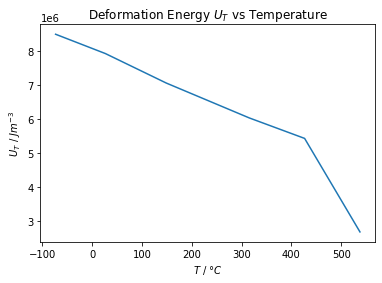

In [15]:
from matplotlib import pyplot as plt

energy_per_volume_unit = 'Jm^{{-3}}'
temperature_unit = '°C'
x_label = rf'$T$ / ${temperature_unit}$'
y_label = rf'$U_T$ / ${energy_per_volume_unit}$'

fig, ax = plt.subplots()
ax.plot(df_results['x'], df_results['y'])
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
_ = ax.set_title('Deformation Energy $U_T$ vs Temperature')

### Compare Deformation Energy at temperature extrema

The area under the high- and low-temperature *Stress-Strain* curves can be shown graphically, providing a
more visual comparison. 

Create a basic *Stress-Strain* plot at both temperatures, dividing the plotted y values by $10^6$ and changing the
y-axis units to MPa. Add the legend manually.

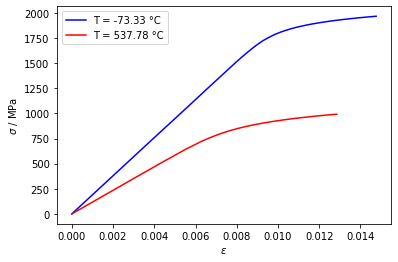

In [16]:
# Low temperature
t_low = df_stress_strain_clean.Temperature.min()
df_ss_t_low = df_stress_strain_clean[df_stress_strain_clean.Temperature == t_low]

# High temperature
t_high = df_stress_strain_clean.Temperature.max()
df_ss_t_high = df_stress_strain_clean[df_stress_strain_clean.Temperature == t_high]

x_label = rf'$\epsilon$'
y_label = rf'$\sigma$ / MPa'

fig, ax = plt.subplots()
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)

ax.plot(df_ss_t_low.x, df_ss_t_low['y'] / 1e6, color='blue', label=f'T = {t_low:.2f} °C')
ax.plot(df_ss_t_high['x'], df_ss_t_high['y'] / 1e6, color='red', label=f'T = {t_high:.2f} °C')

handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels)

Next, use the functions you defined above to calculate the stress-strain curves up to the yield stress.

In [17]:
# Low temperature
xnew_t_low, ynew_t_low = resample_stress_strain(df_ss_t_low.x, df_ss_t_low.y / 1e6, t_low)

# High temperature
xnew_t_high, ynew_t_high = resample_stress_strain(df_ss_t_high.x, df_ss_t_high.y / 1e6, t_high)

Use `ax.fill_between()` to fill the space between the resampled curves and the x-axis, and set the lower limit for both axes to 0. (`fig` forces jupyter to re-plot the existing chart.)

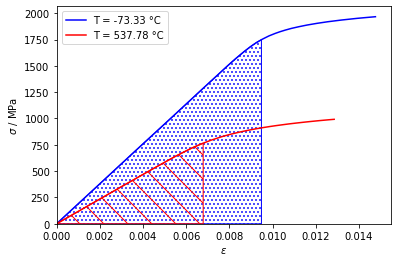

In [18]:
ax.fill_between(xnew_t_low, 0, ynew_t_low, facecolor="none", hatch="...", edgecolor="blue")
ax.fill_between(xnew_t_high, 0, ynew_t_high, facecolor="none", hatch="\\", edgecolor="red")

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

fig

Finally, add a chart title and annotate the filled areas with the corresponding *Deformation Energy*. 

To render the *Deformation Energy* value in standard form, we've defined a function which returns the mantissa and exponent, and inserted them into LaTeX-formatted strings.

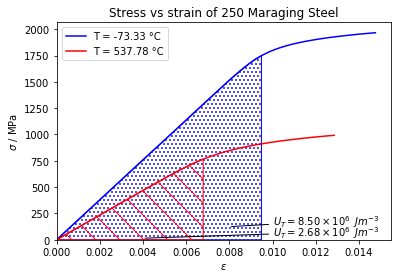

In [19]:
energy_low = df_results.y[0]
energy_high = df_results.y.iloc[-1]

import math

def get_mantissa_and_exponent(x):
    exponent = int(math.floor(math.log10(abs(x))))
    mantissa = x / 10**exponent
    return f'{mantissa:.2f}', f'{exponent}'

arrow_props = {'facecolor': 'black', 'arrowstyle': '-'}

ax.annotate(r'$U_T = {0} \times 10^{{{1}}} \enspace Jm^{{-3}}$'.format(*get_mantissa_and_exponent(energy_low)),
            xy=(0.008, 125),
            xytext=(0.010, 140),
            arrowprops=arrow_props)

ax.annotate(r'$U_T = {0} \times 10^{{{1}}} \enspace Jm^{{-3}}$'.format(*get_mantissa_and_exponent(energy_high)),
            xy=(0.004, 15),
            xytext=(0.010, 35),
            arrowprops=arrow_props)
ax.set_title('Stress vs strain of 250 Maraging Steel')
fig